# Aprendizado de Máquina com Duplo Desviés (*Double Debiased Machine Learning* - DDML)

Prof. Daniel de Abreu Pereira Uhr

### Conteúdo
* Introdução
* Post-Double Selection (Seleção Pós-Dupla)
* 
* Cross-Validation (Validação Cruzada)
  * The Validation Set Approach (A Abordagem do Conjunto de Validação)
  * Leave-One-Out Cross-Validation (Validação Cruzada Leave-One-Out)
  * k-Fold Cross-Validation (Validação Cruzada k-Fold)
* The Bootstrap

### Referências

* [An Introduction to Statistical Learning](https://www.statlearning.com/) (ISL) by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani
  * Capítulo 5***
* [The Elements of Statistical Learning](https://hastie.su.domains/ElemStatLearn/) (ESL) by Trevor Hastie, Robert Tibshirani and Jerome Friedman : 
  * Capítulo 7

***Disclaimer:*** *O material apresentado aqui é uma adaptação do material de aula do Prof. Daniel de Abreu Pereira Uhr, e não deve ser utilizado para fins comerciais. O material é disponibilizado para fins educacionais e de pesquisa, e não deve ser reproduzido sem a devida autorização do autor. Este material pode conter erros e imprecisões. O autor não se responsabiliza por quaisquer danos ou prejuízos decorrentes do uso deste material. O uso deste material é de responsabilidade exclusiva do usuário. Caso você encontre erros ou imprecisões neste material, por favor, entre em contato com o autor para que possam ser corrigidos. O autor agradece qualquer feedback ou sugestão de melhoria.*

Configuração do sistema


In [ ]:
# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# Import everything
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm

from numpy.linalg import inv
from statsmodels.iolib.summary2 import summary_col
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
# Import matplotlib for graphs

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# Set global parameters
%matplotlib inline
plt.style.use('seaborn-v0_8-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

### Introdução

Em um experimento controlado e aleatorizado (*Randomized Controlled Trial* - RCT), o tratamento ($D$) é aleatoriamente atribuído aos participantes, o que permite que os pesquisadores isolem o efeito do tratamento sobre o resultado. E o uso de variáveis de controle ($X$) é geralmente desnecessário, pois a aleatorização garante que os grupos de tratamento e controle sejam comparáveis em todas as características observadas e não observadas. Logo, a utilização das variáveis de controle teria um papel secundário, como o de aumentar o poder estatístico da análise, ao reduzir a variância do estimador.

Em estudos observacionais, onde não há aleatorização do tratamento, o uso de variáveis de controle torna-se essencial para tentar recuperar os efeitos causais. Nesse contexto, as variáveis de controle são utilizadas para ajustar as diferenças pré-existentes entre os grupos de tratamento e controle, permitindo uma melhor aproximação do efeito causal.

Em muitos casos, o pesquisador dispõe de um grande número de variáveis de controle, e surge a necessidade de selecionar aquelas mais relevantes, eventualmente capturando não linearidades e interações. Algoritmos de aprendizado de máquina são particularmente adequados para essa tarefa. No entanto, nesses casos, estamos introduzindo um viés chamado de regularização ou pré-teste (Regularization - Pre-test), ou viés de seleção de características. 

Nesta aula, examinaremos a origem desse viés e apresentaremos uma das soluções mais influentes na última década na interseção entre aprendizado de máquina e inferência causal: o **Aprendizado de Máquina com Duplo Desviés** (*Double Debiased Machine Learning - DDML*).



### Pre-test (Pré-teste)


O ***viés de pre-test*** (de Regularização, ou de Seleção de Características) ocorre quando ***o pesquisador utiliza as variáveis de controle para decidir, com base nos dados, quais covariáveis incluir no modelo final***. Essa seleção pode ser feita com base em testes estatísticos, algoritmos de seleção de variáveis ou, mais recentemente, por meio de algoritmos de aprendizado de máquina com regularização.

Embora essa abordagem possa melhorar a qualidade da previsão, ela pode comprometer a validade da inferência causal. O motivo é que a seleção baseada nos dados introduz dependência entre os estimadores e o processo de seleção, violando pressupostos fundamentais da teoria da inferência estatística clássica.

Na prática, isso significa que:

* O estimador do efeito do tratamento ($\hat{\theta}$) torna-se enviesado;
* A estimativa de seu erro padrão também se torna inválida, dificultando a construção de intervalos de confiança confiáveis;
* Mesmo modelos lineares, como o OLS, podem sofrer com esse problema se a inclusão ou exclusão de variáveis for condicionada aos próprios dados.

Este fenômeno é um exemplo de overfitting inferencial: o modelo se adapta tão bem aos dados observados que perde a validade fora da amostra ou sob pequenas perturbações nos dados.

A solução para esse problema começa com a separação clara entre modelos de previsão (com alta capacidade de ajuste e regularização) e modelos de inferência causal, que precisam ser robustos a esse tipo de viés.


***Exemplo Didático***

Suponha que fôssemos uma empresa e estivéssemos interessados ​​no efeito dos gastos com publicidade na receita.

* Vale a pena investir em publicidade? 

Sabemos que também há muitos outros fatores que podem influenciar as vendas; portanto, estamos pensando em controlar as vendas passadas na análise, a fim de aumentar o poder da nossa análise.



In [2]:
"""Data-generating process class."""

import pandas as pd
from typing import List
from joblib import Parallel, delayed
from abc import abstractmethod


class DGP:

    def __init__(self,
                 n: int,
                 w: str,
                 y: List[str],
                 x: List[str] = [],
                 u: List[str] = [],
                 ):
        """Parameters for the data generating process

        Args:
            n: number of observations
            w: treatment assignment variable
            y: list of outcome names
            x: list of observable variables (confounders, features, ...) names
            u: list of unobservable variables names
        """
        self.n = n
        self.w = w
        self.y = y
        self.x = x
        self.u = u

    def __post_init__(self):
        df = self.initialize_data()
        self.df = self.add_potential_outcomes(df)

    @abstractmethod
    def initialize_data(self, seed: int = 0) -> pd.DataFrame:
        """Generates a dataframe with the baseline variables."""

    @abstractmethod
    def add_potential_outcomes(self, df: pd.DataFrame, seed: int = 0) -> pd.DataFrame:
        """Adds potential outcomes to the dataframe."""

    def check_potential_outcomes(self, df: pd.DataFrame):
        """Check that every potential outcome is in the data."""
        for y in self.y:
            for w in df[self.w].unique():
                assert f"{y}_w{w}" in df.columns

    @abstractmethod
    def add_treatment_assignment(self, df: pd.DataFrame, seed: int = 0) -> pd.DataFrame:
        """Adds the treatment assignment variable."""

    def add_realized_outcomes(self, df: pd.DataFrame, drop_unobservables: bool) -> pd.DataFrame:
        """Add realized outcomes, from potential outcomes and treatment assignment. Drop unobservables upon request."""
        for y in self.y:
            df[y] = 0
            for w in df[self.w].unique():
                df[y] += df[f"{y}_w{w}"] * (df[self.w] == w)
                if drop_unobservables:
                    del df[f"{y}_w{w}"]
        if drop_unobservables:
            for u in self.u:
                del df[u]
        return df

    def post_treatment_processing(self, df: pd.DataFrame, seed: int = 0):
        """Post-treatment processing."""
        return df

    def generate_data(self, seed_dt=0, seed_po=1, seed_as=2, seed_pt=3, drop_unobservables: bool = True, **kwargs) -> pd.DataFrame:
        """Generate potential outcomes, add assignment and select realized outcomes."""
        df = self.initialize_data(seed=seed_dt)
        df = self.add_potential_outcomes(df=df, seed=seed_po, **kwargs)
        df = self.add_treatment_assignment(df=df, seed=seed_as)
        self.check_potential_outcomes(df=df)
        df = self.add_realized_outcomes(df, drop_unobservables=drop_unobservables)
        return self.post_treatment_processing(df=df, seed=seed_pt)

    def evaluate_f_redrawing_data(self, f, n_draws: int):
        """Evaluates the function f on n_draws of the data (data, potential outcomes, and treatment assignment)."""
        results = Parallel(n_jobs=8)(delayed(f)(self.generate_data(seed_dt=i, seed_po=n_draws+1, seed_as=2*n_draws+i)) for i in range(n_draws))
        return results

    def evaluate_f_redrawing_potential_outcomes(self, f, n_draws: int):
        """Evaluates the function f on n_draws of the potential outcomes, and treatment assignment (not the data)."""
        results = Parallel(n_jobs=8)(delayed(f)(self.generate_data(seed_po=n_draws+1, seed_as=2*n_draws+i)) for i in range(n_draws))
        return results
    
    def evaluate_f_redrawing_assignment(self, f, n_draws: int):
        """Evaluates the function f on n_draws of the treatment assignment (not the data, or the potential outcomes)."""
        results = Parallel(n_jobs=8)(delayed(f)(self.generate_data(seed_as=2*n_draws+i)) for i in range(n_draws))
        return results

In [3]:
"""Collection of data-generating processes built over the DGP class."""

import numpy as np
import pandas as pd
from dgp import DGP


class dgp_notification_newsletter(DGP):
    """DGP for instrumental_variables article."""
    X: list[str] = ['spend_old']
    D: str = 'notification'
    Y: list[str] = ['subscription', 'spend']

    def add_assignment(self, df: pd.DataFrame, seed: int = 0) -> pd.DataFrame:
        np.random.seed(seed)
        df[self.D] = np.arange(0, self.n) % 2
        return df

    def generate_potential_outcomes(self, seed: int = 0, true_effect: float = None):
        np.random.seed(seed)
        budget = np.random.exponential(100, self.n)
        u_subscription = np.log(budget) + np.random.normal(-5, 1, self.n)
        subscription_c = 1 * (u_subscription > 0)
        subscription_t = 1 * (u_subscription + 0.7 > 0)
        spend = np.sqrt(budget) + np.random.normal(1, 1, self.n)
        spend_old = np.maximum(0, spend + np.random.normal(0, 1, self.n))
        spend_c = np.maximum(0, spend + 6 * subscription_c)
        spend_t = np.maximum(0, spend + 6 * subscription_t)
        df = pd.DataFrame({'subscription_c': subscription_c, 'subscription_t': subscription_t, 
                           'spend_old': spend_old, 'spend_c': spend_c, 'spend_t': spend_t})
        return df.round(2)


class dgp_gift(DGP):
    """DGP: gift"""
    X: list[str] = ['age', 'rev_old', 'rev_change']
    D: str = 'gift'
    Y: list[str] = ['churn', 'revenue']

    def generate_baseline(self, seed:int = 0):
        np.random.seed(seed)
        months = np.random.exponential(5, self.n)
        rev_old = np.maximum(0, np.random.exponential(7, self.n) - 2)
        rev_change = np.random.normal(0, 2, self.n)
        churn_c = np.random.beta(1 - rev_change*(rev_change<0), 2 + rev_old) > 0.4
        rev_c = 0.8*rev_old + 0.2*np.maximum(0, np.random.exponential(7, self.n) - 2)
        df = pd.DataFrame({'months': months, 'rev_old': rev_old, 'rev_change': rev_change,
                           'churn_c': churn_c, 'revenue_c': rev_c})
        return df

    def add_treatment_effect(self, df, seed:int = 1):
        np.random.seed(seed)
        effect_c = - np.random.binomial(1, 0.3, self.n) * (df.months<7)
        df['effect_on_churn'] = effect_c * (df.churn_c==1)
        effect_r = np.random.normal(0.9, 0.5, self.n)* (df.months>3)
        df['effect_on_revenue'] = np.maximum(-df.revenue_c, effect_r)
        return df

    def add_assignment(self, df: pd.DataFrame, seed: int = 2) -> pd.DataFrame:
        np.random.seed(seed)
        df[self.D] = np.random.binomial(1, 0.5, self.n)
        return df

    def add_post_treatment_variables(self, df : pd.DataFrame, seed: int = 0) -> pd.DataFrame:
        df.revenue *= (1-df.churn)
        return df


class dgp_promotional_email(DGP):
    """DGP: promotional email"""
    X: list[str] = ['new', 'age', 'sales_old']
    D: str = 'mail'
    Y: list[str] = ['sales']

    def generate_baseline(self, seed:int = 0):
        np.random.seed(seed)
        x1 = np.random.binomial(1, 0.4, self.n)
        x2 = np.round(np.random.uniform(20, 60, self.n), 2)
        x3_ = -1.45 + (100/x2) - np.maximum((x2-60)**2/500, 0) + 0.2*x1 
        x3 = np.maximum(np.random.normal(x3_, 0.01), 0)
        y0 = np.maximum(np.random.normal(x3_, 0.05, self.n), 0)
        df = pd.DataFrame({'new': x1, 'age': x2, 'sales_old': x3, 'sales_c': y0})
        return df

    def add_treatment_effect(self, df, seed:int = 0):
        np.random.seed(seed)
        df['effect_on_sales'] = -0.05*(df['age']<30) + 0.08*(df['age']>45)
        return df

    def add_assignment(self, df: pd.DataFrame, seed: int = 0) -> pd.DataFrame:
        np.random.seed(seed)
        df[self.D] = np.random.binomial(1, 0.2 + 0.6*(1-df.new))
        return df


class dgp_online_discounts(DGP):
    """DGP: online discounts"""
    devices = ['desktop', 'mobile']
    browsers = ['chrome', 'safari', 'firefox', 'explorer', 'edge', 'brave', 'other']
    regions = [str(x) for x in range(10)]
    X: list[str] = ['time', 'device', 'browser', 'region']
    D: str = 'discount'
    Y: list[str] = ['spend']

    def generate_baseline(self, seed:int = 0):
        np.random.seed(seed)
        time = np.random.beta(1, 1, size=self.n) * 24
        device = np.random.choice(self.devices, size=self.n)
        browser = np.random.choice(self.browsers, size=self.n)
        region = np.random.choice(self.regions, size=self.n)
        spend_c = np.random.exponential(10, self.n) - 5
        df = pd.DataFrame({'spend_c': spend_c, 'time': time, 'device': device, 'browser': browser, 'region': region})
        return df
    
    def add_treatment_effect(self, df, seed:int = 0):
        np.random.seed(seed)
        effect = 7*np.exp(-(df.time-18)**2/100) + 3*(df.browser=='safari') - 2*(df.device=='desktop') + (df.region=='3') - 2.5
        df['effect_on_spend'] = np.maximum(0, effect)
        return df


class dgp_cloud(DGP):
    """DGP: cloud computing and return on investment."""
    D: str = 'new_machine'
    Y: list[str] = ['cost', 'revenue']
    
    def generate_potential_outcomes(self, seed: int = 0):
        np.random.seed(seed)
        cost_c = np.random.exponential(3, self.n)
        effect = np.random.uniform(0, 1, self.n)
        cost_t = cost_c + effect
        revenue_c = np.random.normal(cost_c*10 - 4, 1, self.n)
        revenue_t = revenue_c + effect * 2
        df = pd.DataFrame({'cost_c': np.maximum(cost_c, 0), 
                           'cost_t': np.maximum(cost_t, 0), 
                           'revenue_c': np.maximum(revenue_c, 0), 
                           'revenue_t': np.maximum(revenue_t, 0)})
        return df.round(2)


class dgp_infinite_scroll(DGP):
    """DGP: work in progress"""
    D: str = 'infinite_scroll'
    Y: list[str] = ['ad_revenue']

    def generate_potential_outcomes(self, seed: int = 0, true_effect: float = None):
        np.random.seed(seed)
        past = np.random.normal(2, 1, self.n)
        outcome_c = np.random.normal(past, 1, self.n)
        avg_effect = np.random.standard_t(1.3) / 300 if true_effect is None else true_effect
        outcome_t = outcome_c + avg_effect
        df = pd.DataFrame({'ad_revenue_c': outcome_c, 'ad_revenue_t': outcome_t, 'past_revenue': past})
        return df.round(2)


class dgp_darkmode():
    """DGP: blog dark mode and time spend reading"""
    assignment_var: str = 'dark_mode'
    outcome_vars: list[str] = ['outcome']

    def generate_data(self, seed: int = 0):
        np.random.seed(seed)
        male = np.random.binomial(1, 0.45, N)
        age = np.rint(18 + np.random.beta(2, 2, N)*50)
        outcome_c = np.random.normal(10, 4, N)
        outcome_t = outcome_c - 4*male + 2*np.log(hours) + 2*dark_mode
        df = pd.DataFrame({'male': male, 'age': age, 'hours': hours,
                          'outcome_c': outcome_c, 'outcome_t': outcome_t})
        return df.round(2)


class dgp_ad():
    """
    Data Generating Process: ads
    """
    
    def __init__(self):
        self.Y = 'revenue'
        self.T = 'ad_exposure'
        self.X = ['male', 'black', 'age', 'educ']
    
    def generate_data(self, seed=1, N=1000, oracle=False):
        np.random.seed(seed)

        # Exogenous observables
        df = pd.DataFrame({'male': np.random.binomial(1, 0.5, N),
                           'black': np.random.binomial(1, 0.5, N),
                           'age': np.rint(np.random.normal(45, 10, N))})

        # Endogenous observables
        df['educ'] = np.random.poisson(2*df['black'] + 1)

        # Treatment
        df[self.T] = (np.random.uniform(0, 2, N) \
                    + 0.3 * df['male'] \
                    - 0.2 * df['black']) > 1

        # Treatment effect
        Y0 =  0.5 * df['male'] \
            - 0.5 * df['black'] \
            + 0.1 * np.log(1 + df['educ']) \
            - 0.2 * (df['age']>50) \
            + rnd(0, 1, N)
        Y1 = Y0 \
            + 0.5 \
            + 0.4 * df['male'] \
            + 0.1 * np.log(1 + df['educ']) \
            + 0.2 * (df['age']>40)
        if oracle:
            df['Y0'] = Y0
            df['Y1'] = Y1
        df[self.Y] = Y0 + Y1 * df[self.T]
       
        return df


class dgp_aipw():
    """
    Data Generating Process for AIPW
    
    from https://www.youtube.com/watch?v=IfZHUFFlsGc
    """
    
    def __init__(self, p=20):
        self.p = p
        self.Y = 'Y'
        self.T = 'T'
        self.X = [f"x{i}" for i in range(1,p+1)]
    
    def generate_data(self, seed=1, N=1000):
        np.random.seed(seed)

        # Exogenous observables
        df = pd.DataFrame(np.random.normal(0, 1, (N, self.p)), columns=self.X)

        # Propensity score
        df['e'] = 1 / (1 + np.exp(- df['x1']))

        # Treatment
        df['T'] = (np.random.uniform(0, 1, N) < df['e']).astype(int)

        # Outcomes
        df['Y0'] = np.maximum(df['x1'] + df['x2'], 0) - 0.05 * df['T']
        df['Y1'] = np.maximum(df['x1'] + df['x3'], 0) - 0.05 * df['T'] - 0.05
        df['Y'] = df['Y0'] * (1-df['T']) + df['Y1'] * df['T']

        return df


class dgp3():
    """
    Data Generating Process 3
    """
    
    def __init__(self, p=20):
        self.p = p
        self.Y = 'Y'
        self.T = 'T'
        self.X = [f"x{i}" for i in range(1,p+1)]
    
    def generate_data(self, seed=1, N=1000):
        np.random.seed(seed)

        # Exogenous observables
        df = pd.DataFrame(np.random.normal(0, 1, (N, self.p)), columns=self.X)

        # Propensity score
        df['e'] = 1 / (1 + np.exp(- df['x1']))

        # Treatment
        df['T'] = (np.random.uniform(0, 1, N) < df['e']).astype(int)

        # Outcomes
        df['Y'] = np.maximum(df['x1'] + df['x2'] * (1-df['T']) + df['x3'] * df['T'], 0) - 0.05 * df['T']

        return df


class dgp4():
    """
    Data Generating Process 4
    
    from https://www.youtube.com/watch?v=N9ThAs7NS0g
    """
    
    def __init__(self, p=10):
        self.p = p
        self.Y = 'Y'
        self.T = 'T'
        self.X = [f"x{i}" for i in range(1,p+1)]
    
    def generate_data(self, seed=1, N=4000):
        np.random.seed(seed)

        # Exogenous observables
        df = pd.DataFrame(np.random.normal(0, 1, (N, self.p)), columns=self.X)

        # Treatment probability
        df['e'] = 0.3

        # Treatment assignment
        df['T'] = (np.random.uniform(0, 1, N) < df['e']).astype(int)
        
        # Treatment effect
        df['tau'] = 1 / (1 + np.exp(-df['x3']))

        # Outcomes
        df['Y'] = np.maximum(df['x1'] + df['x2'], 0) + df['T'] * df['tau'] + np.random.normal(0, 1, N)

        return df


class dgp_newsletter():
    """
    Data Generating Process: reminder to sign up to newsletter
    """
    
    def __init__(self):
        self.Z = 'reminder'
        self.T = 'subscribe'
        self.Y = 'revenue'
        self.X = []
    
    def generate_data(self, seed=1, N=1000, oracle=False):
        np.random.seed(seed)
        
        # Nudge / instrument
        df = pd.DataFrame({self.Z: np.random.binomial(1, 0.5, N)})
        
        # Hidden type
        income = np.random.exponential(1, N)
        if oracle: df['income'] = income
            
        # Treatment assignment
        df[self.T] = (expit(- income + df[self.Z] + rnd(size=N)) > 0.5).astype(int)
        
        # Treatment effect
        tau = 1
        if oracle: df['tau'] = tau

        # Outcome
        df[self.Y] = -1 + 2*income + tau*df[self.T] + rnd(size=N)

        return df



class dgp_membership():
    """
    Data Generating Process: Incentives for membership
    
    inspired by: https://github.com/microsoft/EconML/blob/main/notebooks/CustomerScenarios
    """
    
    def __init__(self):
        self.Z = 'easier_signup'
        self.T = 'became_member'
        self.Y = 'revenue_post'
        self.X = []
    
    def generate_data(self, seed=1, N=100000, oracle=False):
        np.random.seed(seed)

        # Exogenous observables
        df = pd.DataFrame({'visit_flights': np.random.randint(0, 28, N),
                           'visit_hotels': np.random.randint(0, 28, N),
                           'visit_restaurants': np.random.randint(0, 28, N),
                           'visit_rental': np.random.randint(0, 28, N),
                           'origin_US': np.random.binomial(1, 0.7, N),
                           'mobile': np.random.binomial(1, 0.3, N),
                           'revenue_pre': np.random.exponential(1, N)})
        self.X = df.columns
        
        # Hidden type
        income = np.random.exponential(1, N)

        # Nudge / instrument
        df[self.Z] = np.random.binomial(1, 0.5, N)

        # Treatment probability
        e = expit(- income + df[self.Z] + rnd(size=N))
        if oracle: df['e'] = e
        
        # Treatment assignment
        df[self.T] = (np.random.uniform(0, 1, N) < e).astype(int)
        
        # Treatment effect
        tau = 0.2 + 0.3 * df['visit_flights'] - 0.2*df['visit_rental'] + df['mobile']
        if oracle: df['tau'] = tau

        # Outcome
        df[self.Y] = 1 + df['revenue_pre'] + 2*income + tau*df[self.T] + rnd(size=N)

        return df.round(2)
    

class dgp_ao18():
    """
    Data Generating Process: Anna and Olken (2018)
    
    inspired by: https://github.com/microsoft/EconML/blob/main/notebooks/CustomerScenarios
    """
    
    def __init__(self):
        self.T = 'cash_transfer'
        self.Y = 'welfare'

    def import_data(self, seed=1, oracle=False):
        np.random.seed(seed)

        # Import data
        df = pd.read_csv('data/ao18.csv')
        
        self.X = [c for c in df.columns if c not in ['hhid', 'consumption_0']]

        # Treatment 
        df['cash_transfer'] = np.random.binomial(1, 0.5, len(df))

        # Treatment effect
        df['consumption'] = df['consumption_0'] + df['cash_transfer']*100

        # Hide 
        df['welfare'] = np.log(df['consumption'])

        # Hide variables
        if oracle:
            df['welfare_0'] = np.log(df['consumption_0'])
            df['welfare_1'] = np.log(df['consumption_0'] + 100)
        else:
            df = df.drop(columns=['consumption_0'])

        # Return
        return df.dropna()
    

class dgp_did():
    """
    Data Generating Process: TV advertising
    
    Inspired by: https://matheusfacure.github.io/python-causality-handbook/13-Difference-in-Differences.html
    """
    
    def __init__(self):
        self.D = 'treated'
        self.Y = 'revenue'
        self.T = 'days'

    def generate_data(self, seed=1, N=100, T=20, oracle=False):
        np.random.seed(seed)

        # Init data
        df = pd.DataFrame(np.array(np.meshgrid(range(1, T+1), range(1,N), [0,1])).T.reshape(-1,3), 
                  columns=['day', 'id', 'treated'])
        #df['treated'] = df['treated'].astype('bool')
        
        
        # Treatment
        alpha_i = np.sqrt(df['id']) - 3*(df['id']>10)
        gamma_t = 0.1*df['day'] + rnd(size=len(df))
        tau_it = 0.5*np.log(1+df['id']) - 0.12*df['day']
        
        # Effect
        df['post'] = (df['day'] > T/2)
        df['revenue'] = alpha_i + gamma_t + \
                        1.2*df['treated'] + \
                        df['post']*df['treated']*tau_it + \
                        rnd(size=len(df))
        
        # Hide variables
        if oracle:
            df['alpha_i'] = alpha_i
            df['gamma_t'] = gamma_t
            df['tau_it'] = tau_it

        # Return
        return df
    
    
class dgp_school():
    """
    Data Generating Process: class size and test scores
    """
    
    def __init__(self):
        self.T = 'class_size'
        self.Y = 'math_score'
    
    def generate_data(self, seed=1, N=1000, oracle=False):
        np.random.seed(seed)
        
        # Dataframe
        df = pd.DataFrame({'math_hours': np.random.randint(2,5,N),
                           'history_hours': np.random.randint(2,5,N),
                           'good_school': np.random.binomial(1,0.5,N),
                           'class_year': np.random.randint(1,5,N)})
        
        # Treatment
        df[self.T] = np.random.poisson(25, N) - 1*df['class_year'] - 7*df['good_school']
        
        # Hidden ability
        ability = np.random.exponential(1, N)
        history_hours = np.random.randint(3,5,N)
            
        # Main outcome
        df[self.Y] = 1 + 0.2*df[self.T] + ability + df['math_hours'] + 5*df['good_school'] + rnd(size=N)
        
        # Other outcome
        df['hist_score'] = 1 + 0.2*df[self.T] + ability + history_hours + 5*df['good_school'] + rnd(size=N)
                
        return df
    

class dgp_marketplace():
    """
    Data Generating Process: online marketplace
    """
    
    def generate_data(self, seed=1, N=10_000):
        np.random.seed(seed)
        
        # Does the firm sells only online?
        online = np.random.binomial(1, 0.5, N)
        
        # How many products does the firm have
        products = 1 + np.random.poisson(1, N)
        
        # What is the age of the firm
        t = np.random.exponential(0.5*products, N) 
        
        # Sales
        sales = 1e3 * np.random.exponential(products + np.maximum((1 + 0.3*products + 4*online)*t - 0.5*(1 + 6*online)*t**2, 0), N)

        # Generate the dataframe
        df = pd.DataFrame({'age': t, 'sales': sales, 'online': online, 'products': products})
                
        return df
    
    
    
class dgp_store_coupons():
    """
    Data Generating Process: store coupons
    """
    
    def generate_data(self, seed=1, N=300, K=5):
        np.random.seed(seed)
        
        # Incomme
        income = np.round(np.random.normal(50, 10, N), 3) 
        
        # Using a coupon
        coupons = np.round(np.random.normal(0.5, 0.1, N) - income / 200, 3)
        
        # Day of the week
        day = np.random.choice(range(1,8), N)
        
        # Sales
        sales = np.round(10 * (income + 20*coupons + day + np.random.normal(10, 2, N)), 1)

        # Generate the dataframe
        df = pd.DataFrame({'sales': sales, 'coupons': coupons, 'income': income, 'dayofweek': [str(d) for d in day]})

        return df

    
class dgp_educ_wages():
    """
    Data Generating Process: aducation and wages
    """
    
    def generate_data(self, seed=1, N=300):
        np.random.seed(seed)
        
        # Ability
        ability = np.round(np.random.uniform(0, 10, N), 3) 
        
        # Controls 
        age = np.random.randint(25, 65, N)
        gender = np.random.choice(['male', 'female'], N)
        
        # Education
        education = np.random.randint(5, 10, N) + ability//3
        
        # Wage
        wage = 100 * np.round(ability/2 + education + 8*np.log(age) + 2*(gender=='male') + np.random.normal(0, 4, N))
        
        # Generate the dataframe
        df = pd.DataFrame({'age': age, 'gender': gender, 'education': education, 'wage': wage})

        return df
    
    
class dgp_pretest():
    """
    Data Generating Process: pre-test bias
    """
    
    def generate_data(self, a=1, b=.3, c=3, N=1000, seed=1):
        np.random.seed(seed)
        
        # Past Sales
        past_sales = np.random.normal(5, 1, N)
        
        # Advertisement 
        ads = c*past_sales + np.random.normal(-3, 1, N)
        
        # Education
        sales = a*ads + b*past_sales + np.random.normal(0, 1, N)
                
        # Generate the dataframe
        df = pd.DataFrame({'ads': ads, 'sales': sales, 'past_sales': past_sales})

        return df
    
    
class dgp_rnd_assignment():
    """
    Data Generating Process: random assignment 
    """
    
    def generate_data(self, N=1000, seed=1):
        np.random.seed(seed)
        
        # Treatment assignment
        group = np.random.choice(['treatment', 'control'], N, p=[0.3, 0.7])
        arm_number = np.random.choice([1,2,3,4], N)
        arm = [f'arm {n}' for n in arm_number]

        # Covariates 
        gender = np.random.binomial(1, 0.5 + 0.1*(group=='treatment'), N) 
        age = np.rint(18 + np.random.beta(2 + (group=='treatment'), 5, N)*50)
        mean_income = 6 + 0.1*arm_number
        var_income = 0.2 + 0.1*(group=='treatment')
        income = np.round(np.random.lognormal(mean_income, var_income, N), 2)

        # Generate the dataframe
        df = pd.DataFrame({'Group': group, 'Arm': arm, 'Gender': gender, 'Age': age, 'Income': income})
        df.loc[df['Group']=='control', 'Arm'] = np.nan

        return df


class dgp_buttons():
    """
    Data Generating Process: buttons
    """
    
    def __init__(self):
        self.effects = [1,-4]
        self.groups = [' default', 'button1', 'button2']
    
    def generate_data(self, N=1000, seed=1, truth=False):
        np.random.seed(seed)
        
        # Device group
        mobile = np.random.binomial(1, 0.5, N)
        
        # Treatment assignment
        group = pd.Series(mobile)
        group[mobile==True] = np.random.choice(self.groups, p=[0.4, 0.2, 0.4], size=sum(mobile==True))
        group[mobile==False] = np.random.choice(self.groups, p=[0.4, 0.4, 0.2], size=sum(mobile==False))
        
        # Effects
        effect1 = np.random.normal(self.effects[0]*(mobile==True), 1)
        effect2 = np.random.normal(self.effects[1]*(mobile==False), 1)
        revenue = (effect1 + effect2)*(group==self.groups[2]) + 3*mobile + np.random.normal(10, 1, N)
                
        # Generate the dataframe
        df = pd.DataFrame({'group': group, 'revenue': revenue, 'mobile': mobile})
        
        # Add true effects
        if truth: 
            df['effect'] = (effect1 + effect2)*(group=='treat2')

        return df
    
    
class dgp_cuped():
    """
    Data Generating Process: CUPED
    """
    
    def __init__(self, alpha=5, beta=0, gamma=3, delta=2):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
    
    def generate_data(self, N=100, seed=1):
        np.random.seed(seed)
        
        # Individuals
        i = range(1,N+1)

        # Treatment status
        d = np.random.binomial(1, 0.5, N)
        
        # Individual outcome pre-treatment
        y0 = self.alpha + self.beta*d + np.random.normal(0, 1, N)
        y1 = y0 + self.gamma + self.delta*d + np.random.normal(0, 1, N)

        # Generate the dataframe
        df = pd.DataFrame({'i': i, 'ad_campaign': d, 'revenue0': y0, 'revenue1': y1})

        return df
    

class dgp_darkmode():
    """
    Data Generating Process: blog dark mode and time spend reading
    """
    
    def generate_data(self, N=300, seed=1):
        np.random.seed(seed)
        
        # Control variables
        male = np.random.binomial(1, 0.45, N)
        age = np.rint(18 + np.random.beta(2, 2, N)*50)
        hours = np.minimum(np.round(np.random.lognormal(5, 1.3, N), 1), 2000)
        
        # Treatment
        pr = np.maximum(0, np.minimum(1, 0.8 + 0.3*male - np.sqrt(age-18)/10))
        dark_mode = np.random.binomial(1, pr, N)==1
        
        # Outcome
        read_time = np.round(np.random.normal(10 - 4*male + 2*np.log(hours) + 2*dark_mode, 4, N), 1)

        # Generate the dataframe
        df = pd.DataFrame({'read_time': read_time, 'dark_mode': dark_mode, 'male': male, 'age': age, 'hours': hours})

        return df
    
    
class dgp_compare():
    """
    Data Generating Process: a lot of stuff together
    """
    
    def generate_data(self, N=10000, seed=1, include_beta=False):
        np.random.seed(seed)
        
        # Control variables
        male = np.random.binomial(1, 0.5, N)
        age = np.rint(18 + np.random.beta(2, 2, N)*50)
        income = np.rint(np.random.lognormal(7.5, .3, N))
        
        # Treatment assignment
        pr = np.maximum(0, np.minimum(1, 0.55 - 0.1*male + np.sqrt(age)/3 - np.log(income)/3.6))
        d = np.random.binomial(1, pr, N)==1
        
        # Treatment effect
        beta = np.random.normal(3*male - np.sqrt(age) + 2*np.log(income))
        beta = beta - np.mean(beta) + 2
        
        # Outcome
        y = np.round(np.random.normal(20 + 3*male - np.sqrt(age) + 2*np.log(income) + beta*d, 5, N), 2)

        # Generate the dataframe
        df = pd.DataFrame({'outcome': y, 'treated': d, 'male': male, 'age': age, 'income': income})
        if include_beta:
            df['beta'] = beta

        return df


class dgp_premium():
    """
    Data Generating Process: premium
    """
    
    def generate_data(self, N=300, seed=1, true_te=False):
        np.random.seed(seed)
        
        # Control variables
        age = np.round(np.random.uniform(18, 60, N), 2)
        
        # Treatment
        premium = np.random.binomial(1, 0.1, N)==1
        
        # Heterogeneous effects
        y0 = 10 + 0.1*(30<age)*(age<50)
        y1 = 0.5 + 0.3*(35<age)*(age<45)
        
        # Outcome
        revenue = np.round(np.random.normal(y0 + premium*y1, 0.15, N), 2)

        # Generate the dataframe
        df = pd.DataFrame({'revenue': revenue, 'premium': premium, 'age': age})
        
        # Add truth
        if true_te:
            df['y0'] = y0
            df['y1'] = y1

        return df
    
    
    
class dgp_selfdriving():
    """
    Data generating process: self-driving cars
    """
    
    def clean_data():
        df = pd.read_csv('../data/us_cities_20022019.csv')
        df = df[['Metropolitan areas', 'Variables', 'Year', 'Value']]
        df.columns = ['city', 'variable', 'year', 'value']
        df.loc[df['variable'].str.contains('Employment'), "variable"] = "employment"
        df.loc[df['variable'].str.contains('Population density'), "variable"] = "density"
        df.loc[df['variable'].str.contains('Population'), "variable"] = "population"
        df.loc[df['variable'].str.contains('GDP'), "variable"] = "gdp"
        df = pd.pivot(data=df, index=['city', 'year'], columns='variable').reset_index()
        df.columns = [''.join(col).replace('value', '') for col in df.columns]
        df['employment'] = df['employment'] / df['population']
        df['city'] = df['city'].str.replace('\(\w+\)', '').str.strip()
        df['population'] = df['population'] / 1e6
        df['gdp'] = df['gdp'] / 1e4
        df.to_csv('../data/us_cities_20022019_clean.csv', index=False)
        
        
    def generate_data(self, city='Chicago', year=2010, seed=1):
        np.random.seed(seed)
        
        # Load Data
        df = pd.read_csv('../data/us_cities_20022019_clean.csv')
        df = df[df['year']>2002]

        # Select only big cities
        df['mean_pop'] = df.groupby('city')['population'].transform('mean')
        df = df[df['mean_pop'] > 1].reset_index(drop=True)
        del df['mean_pop']

        # Treatment
        df['treated'] = df['city']==city
        df['post'] = df['year']>=year

        # Generate revenue
        df['revenue'] = df['gdp'] + np.sqrt(df['population']) + \
            20*np.sqrt(df['employment']) - df['density']/100 + \
            (df['year']-1990)/5 + np.random.normal(0,1,len(df)) + \
            df['treated'] * df['post'] * np.log(np.maximum(2, df['year']-year))
        
        return df


class dgp_p2p():
    """
    Data Generating Process: blog dark mode and time spend reading
    """

    def generate_data(self, N=50, seed=2):
        np.random.seed(seed)

        # Hours spent in game
        hours = 2 + np.round(np.random.normal(1, 1, N), 1)

        # Transactions
        transactions = np.round(np.random.normal(3*hours, 0.5, N), 2)

        # Generate the dataframe
        df = pd.DataFrame({'hours': hours, 'transactions': transactions})

        # Generate outliers
        df.loc[1,:] = [2, 8]
        df.loc[2,:] = [7, 21]
        df.loc[3,:] = [6.7, 18]

        return df
    
    
class dgp_credit():
    """
    Data Generating Process: credit cards
    """

    def generate_data(self, N=100, seed=0):
        np.random.seed(seed)
        
        # Connection speed
        connection = np.random.lognormal(3, 1, N)
        
        # Treatment assignment
        newUI = np.random.binomial(1, 0.5, N)
        
        # Transfer speed
        transfer = np.minimum(np.random.exponential(10 + 4*newUI - 0.5*np.sqrt(connection), N), connection)
        transfer = np.minimum(np.random.lognormal(2.8 + newUI, 1, N), connection)
        
        # Generate the dataframe
        df = pd.DataFrame({'newUI': newUI,  
                           'connection': np.round(connection,2), 
                           'transfer': np.round(transfer,2)})

        return df


class dgp_loyalty():
    """
    Data Generating Process: loyalty card
    """

    def generate_data(self, seed=1, N=10_000):
        np.random.seed(seed)

        # Treatment
        age = np.random.randint(18, 55, N)
        gender = np.random.choice(['Male', 'Female'], p=[0.6, 0.4], size=N)
        income = np.random.lognormal(4 + np.log(age), 0.1, N)
        loyalty = np.random.binomial(1, 0.5, N)

        # Spend
        spend = 50*(gender=='Female') + income/10 + loyalty*np.sqrt(age)
        spend = np.maximum(np.round(spend, 2) - 220, 0)

        # Generate the dataframe
        df = pd.DataFrame({'loyalty': loyalty, 'spend': spend, 'age': age, 'gender': gender})

        return df

ModuleNotFoundError: No module named 'dgp'



Teorema de Frisch-Waugh
Considere os dados
com DGP:


. Os seguintes estimadores de
são numericamente equivalentes (se
tem classificação completa):

OLS:
de regredir
sobre
Partializando:
de regredir
sobre
Parcialização “dupla”:
de regredir
sobre
onde a operação de passagem para
para
é chamado de projeção para fora
, por exemplo
são os resíduos da regressão
sobre
.


Ou seja, fizemos o seguinte:

regredir
sobre
calcular
calcular os resíduos
Agora, exploramos o teorema por meio de simulação. Em particular, geramos uma amostra a partir do seguinte modelo:


onde
e
.

In [4]:
np.random.seed(1)

# Init
n = 1000
a = 1
b = -.3

# Generate data
x = np.random.uniform(0,1,n).reshape(-1,1)
z = np.random.uniform(0,1,n).reshape(-1,1)
e = np.random.normal(0,1,n).reshape(-1,1)
y = a*x + b*z + e

In [5]:
# Estimate alpha by OLS
xz = np.concatenate([x,z], axis=1)
ols_coeff = inv(xz.T @ xz) @ xz.T @ y
alpha_ols = ols_coeff[0][0]

print('alpha OLS: %.4f (true=%1.0f)' % (alpha_ols, a))

alpha OLS: 1.0928 (true=1)


O estimador de parcialização.

In [6]:
# Partialling out
x_tilde = (np.eye(n) - z @ inv(z.T @ z) @ z.T ) @ x
alpha_po = inv(x_tilde.T @ x_tilde) @ x_tilde.T @ y

print('alpha partialling out: %.4f (true=%1.0f)' % (alpha_po, a))

alpha partialling out: 1.0928 (true=1)


E, por último, o estimador de dupla partição.

In [7]:
# "Double" partialling out
y_tilde = (np.eye(n) - z @ inv(z.T @ z) @ z.T ) @ y
alpha_po2 = inv(x_tilde.T @ x_tilde) @ x_tilde.T @ y_tilde

print('alpha double partialling out: %.4f (true=%1.0f)' % (alpha_po2, a))

alpha double partialling out: 1.0928 (true=1)


Viés de variável omitida
Considere dois modelos estatísticos distintos. Suponha a seguinte regressão longa de interesse:


Defina a regressão curta correspondente como


Teorema OVB
Suponha que o DGP para a regressão longa corresponda a
,
. Suponha ainda que
,
,
. Então, a menos que
ou
é ortogonal a
, o (único) regressor estocástico
está correlacionado com o termo de erro na regressão curta, o que implica que o estimador MCO da regressão curta é inconsistente para
devido ao viés da variável omitida. Em particular, pode-se mostrar que o plim do estimador MCO de
da curta regressão é

 
 

Considere os dados
, onde o verdadeiro modelo é:

 

Vamos investigar o Viés da Variável Omitida por simulação. Em particular, geramos uma amostra a partir do seguinte modelo:

 

onde
e
.

In [9]:
def generate_data(a, b, c, n):

    # Generate data
    z = np.random.normal(0,1,n).reshape(-1,1)
    u = np.random.normal(0,1,n).reshape(-1,1)
    x = c*z + u
    e = np.random.normal(0,1,n).reshape(-1,1)
    y = a*x + b*z + e
    
    return x, y, z

Primeiro, vamos calcular o valor do estimador MCO.

In [10]:
# Init
n = 1000
a = 1
b = -.3
c = 3
x, y, z = generate_data(a, b, c, n)

# Estimate alpha by OLS
ols_coeff = inv(x.T @ x) @ x.T @ y
alpha_short = ols_coeff[0][0]

print('alpha OLS: %.4f (true=%1.0f)' % (alpha_short, a))

alpha OLS: 0.9115 (true=1)


No nosso caso, o viés esperado é:

 
 
 
 

que no nosso caso é
 
.

In [11]:
# Expected bias
bias = alpha_short - a
exp_bias = b * c / (c**2 + 1)

print('Empirical bias: %.4f \nExpected bias:  %.4f' % (bias, exp_bias))

Empirical bias: -0.0885 
Expected bias:  -0.0900


### Viés pré-teste

Considere os dados
, onde o verdadeiro modelo é:

 

Onde
é a variável de interesse (queremos fazer inferência sobre
) e
é um conjunto de variáveis ​​de controle de alta dimensão.

A partir de agora, trabalharemos com as seguintes premissas:

para todos
uniformemente delimitado em
Exogeneidade estrita:
e
e
têm dimensão (e, portanto, valor) que dependem de
Procedimento de pré-teste:

Regress
sobre
e
Para cada
calcular uma estatística de teste
Deixar
para alguma constante
(conjunto de coeficientes estatisticamente significativos).
Execute novamente o novo “modelo” usando
(ou seja, usando as covariáveis ​​selecionadas com coeficientes estatisticamente significativos).
Execute inferência estatística (ou seja, intervalos de confiança e testes de hipóteses) como se nenhuma seleção de modelo tivesse sido feita.
O pré-teste leva a inferências incorretas. Por quê? Por causa de erros de teste na primeira etapa.

In [12]:
# T-test
def t_test(y, x, k):
    beta_hat = inv(x.T @ x) @ x.T @ y
    residuals = y - x @ beta_hat
    sigma2_hat = np.var(residuals)
    beta_std = np.sqrt(np.diag(inv(x.T @ x)) * sigma2_hat )
    return beta_hat[k,0]/beta_std[k]

Em primeiro lugar, o teste t para
:

 

onde o desvio padrão do coeficiente ols é dado por


onde estimamos a variância do termo de erro com a variância dos resíduos



In [13]:
# Pre-testing
def pre_testing(a, b, c, n, simulations=1000):
    np.random.seed(1)
    
    # Init
    alpha = {'Long': np.zeros((simulations,1)),
            'Short': np.zeros((simulations,1)),
            'Pre-test': np.zeros((simulations,1))}

    # Loop over simulations
    for i in range(simulations):
        
        # Generate data
        x, y, z = generate_data(a, b, c, n)
        xz = np.concatenate([x,z], axis=1)
        
        # Compute coefficients
        alpha['Long'][i] = (inv(xz.T @ xz) @ xz.T @ y)[0][0]
        alpha['Short'][i] = inv(x.T @ x) @ x.T @ y
        
        # Compute significance of z on y
        t = t_test(y, xz, 1)
        
        # Select specification based on test
        if np.abs(t)>1.96:
            alpha['Pre-test'][i] = alpha['Long'][i]
        else:
            alpha['Pre-test'][i] = alpha['Short'][i]
    
    return alpha

Vamos comparar as diferentes estimativas.

In [14]:
# Get pre_test alpha
alpha = pre_testing(a, b, c, n)

for key, value in alpha.items():
    print('Mean alpha %s = %.4f' % (key, np.mean(value)))

Mean alpha Long = 0.9994
Mean alpha Short = 0.9095
Mean alpha Pre-test = 0.9925


O coeficiente de pré-teste é muito próximo do coeficiente verdadeiro.

No entanto, o principal efeito do pré-teste é na inferência. Com o pré-teste, a distribuição do estimador deixa de ser gaussiana.

In [19]:
def plot_alpha(alpha, a):
    fig = plt.figure(figsize=(17, 6))

    # Plot distributions
    x_max = np.max([np.max(np.abs(x - a)) for x in alpha.values()])

    # All axes
    k = len(alpha.keys())
    for i, key in enumerate(alpha.keys()):
        # Adiciona subplot na posição correta
        ax = fig.add_subplot(1, k, i + 1)
        ax.hist(alpha[key], bins=30)
        ax.set_title(key)
        ax.set_xlim([a - x_max, a + x_max])
        ax.axvline(a, c='r', ls='--')
        legend_text = [r'$\alpha_0=%.0f$' % a, r'$\hat \alpha=%.4f$' % np.mean(alpha[key])]
        ax.legend(legend_text, prop={'size': 10})

    plt.tight_layout()
    plt.show()


Vamos comparar os estimadores longos, curtos e de pré-teste.

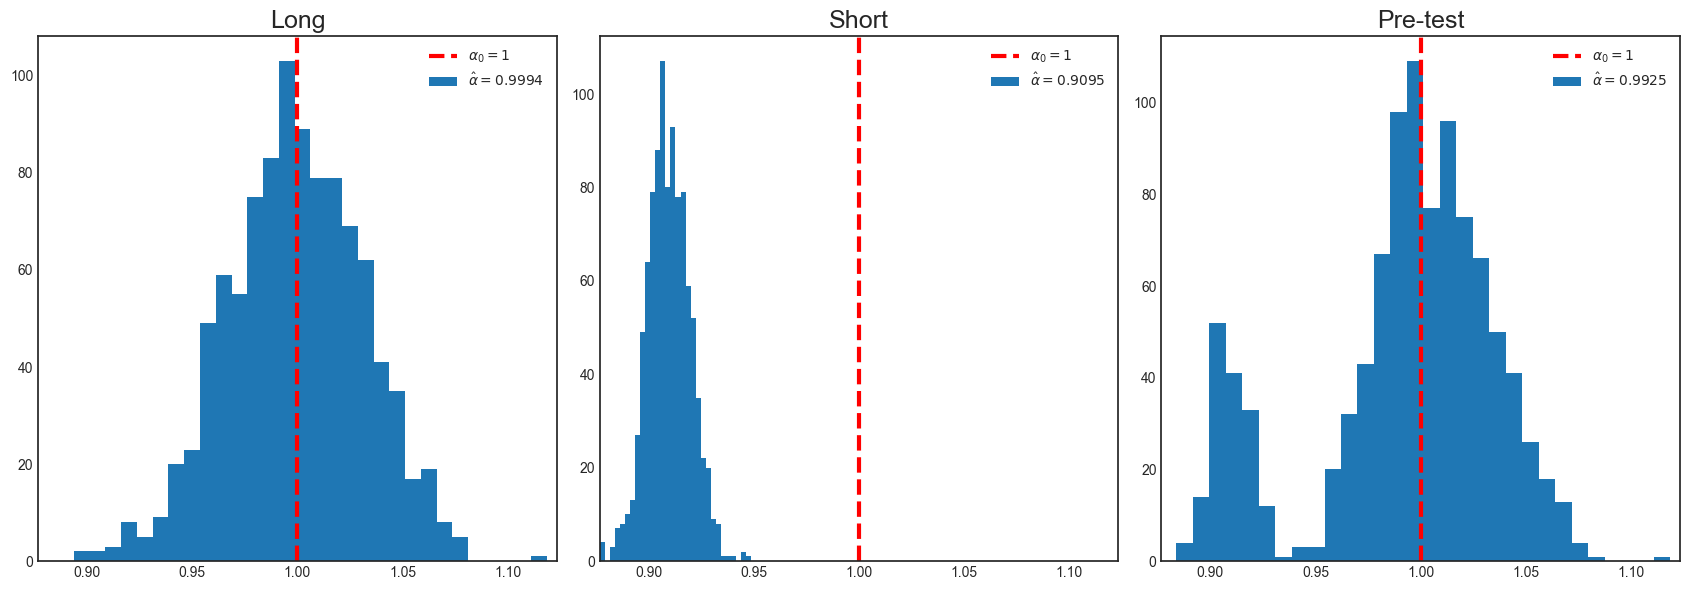

In [20]:
# Plot
plot_alpha(alpha, a)

Como podemos ver, o principal problema do pré-teste é a inferência.

Devido ao procedimento de teste, a distribuição do estimador é uma combinação de duas distribuições diferentes: a resultante da regressão longa e a resultante da regressão curta. O pré-teste não é um problema em 3 casos :

quando
é muito grande: neste caso o teste sempre rejeita a hipótese nula
e sempre executamos a especificação correta, ou seja, a regressão longa

quando
é muito pequeno: neste caso, o teste tem poder muito baixo. No entanto, como vimos na fórmula do Viés da Variável Omitida, o viés é pequeno.

quando
é muito pequeno: também neste caso, o teste tem poder muito baixo. No entanto, como vimos na fórmula do Viés da Variável Omitida, o viés é pequeno.

Vamos comparar as estimativas do pré-teste para diferentes valores do parâmetro verdadeiro
.

In [21]:
# Case 1: different betas and same sample size
b_sequence = b*np.array([0.1,0.3,1,3])
alpha = {}

# Get sequence
for k, b_ in enumerate(b_sequence):
    label = 'beta = %.2f' % b_
    alpha[label] = pre_testing(a, b_, c, n)['Pre-test']
    print('Mean alpha with beta=%.2f: %.4f' % (b_, np.mean(alpha[label])))

Mean alpha with beta=-0.03: 0.9926
Mean alpha with beta=-0.09: 0.9826
Mean alpha with beta=-0.30: 0.9925
Mean alpha with beta=-0.90: 0.9994


As médias são semelhantes, mas vamos analisar as distribuições.

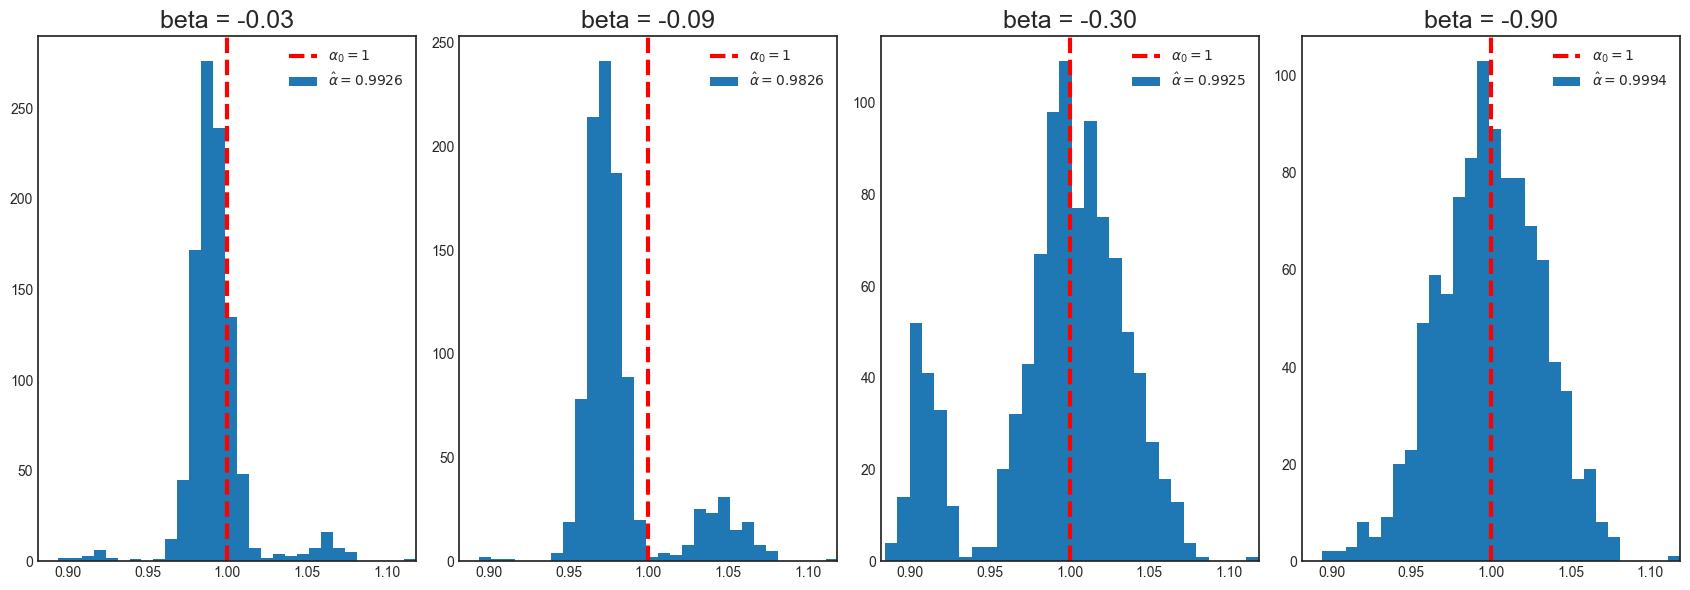

In [22]:
# Plot
plot_alpha(alpha, a)

Quando
é “pequena”, a distribuição do estimador de pré-teste para
não é normal.

No entanto, a magnitude de
é um conceito relativo. Para um tamanho de amostra infinito,
sempre será “grande o suficiente”, no sentido de que com um tamanho de amostra infinito a probabilidade de falsos positivos no teste
vai para zero. Ou seja, sempre selecionamos a especificação correta do modelo, a regressão longa.

Vamos dar uma olhada na distribuição de
quando o tamanho da amostra aumenta.

In [23]:
# Case 2: same beta and different sample sizes
n_sequence = [100,300,1000,3000]
alpha = {}

# Get sequence
for k, n_ in enumerate(n_sequence):
    label = 'n = %.0f' % n_
    alpha[label] = pre_testing(a, b, c, n_)['Pre-test']
    print('Mean alpha with n=%.0f: %.4f' % (n_, np.mean(alpha[label])))

Mean alpha with n=100: 0.9442
Mean alpha with n=300: 0.9635
Mean alpha with n=1000: 0.9925
Mean alpha with n=3000: 0.9989


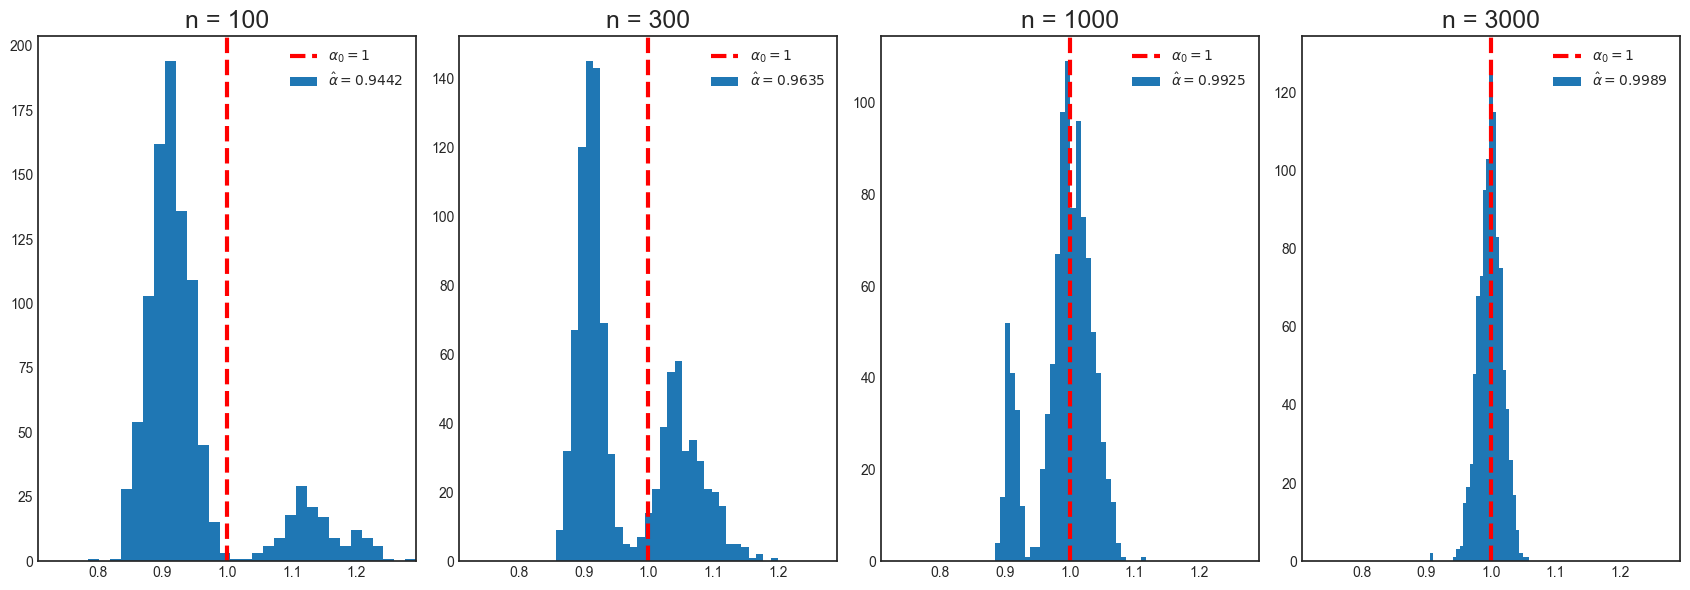

In [24]:
# Plot
plot_alpha(alpha, a)

Como podemos ver, para amostras grandes,
nunca é “pequeno”. No limite, quando
, a probabilidade de falsos positivos durante o teste
vai a zero.

Enfrentamos um dilema:

o pré-teste é claramente um problema em amostras finitas
todos os nossos resultados econométricos são baseados na suposição de que
O problema é resolvido assumindo que o valor de
depende do tamanho da amostra. Isso pode parecer uma suposição estranha, mas serve apenas para ter um conceito assintoticamente significativo de "grande" e "pequeno".

Agora vamos ver o que acontece nas simulações quando
é proporcional a
 
.

In [25]:
# Case 3: beta proportional to 1/sqrt(n) and different sample sizes
beta =  b * 30 / np.sqrt(n_sequence)

# Get sequence
alpha = {}
for k, n_ in enumerate(n_sequence):
    label = 'n = %.0f' % n_
    alpha[label] = pre_testing(a, beta[k], c, n_)['Pre-test']
    print('Mean alpha with n=%.0f: %.4f' % (n_, np.mean(alpha[label])))

Mean alpha with n=100: 0.9703
Mean alpha with n=300: 0.9838
Mean alpha with n=1000: 0.9914
Mean alpha with n=3000: 0.9947


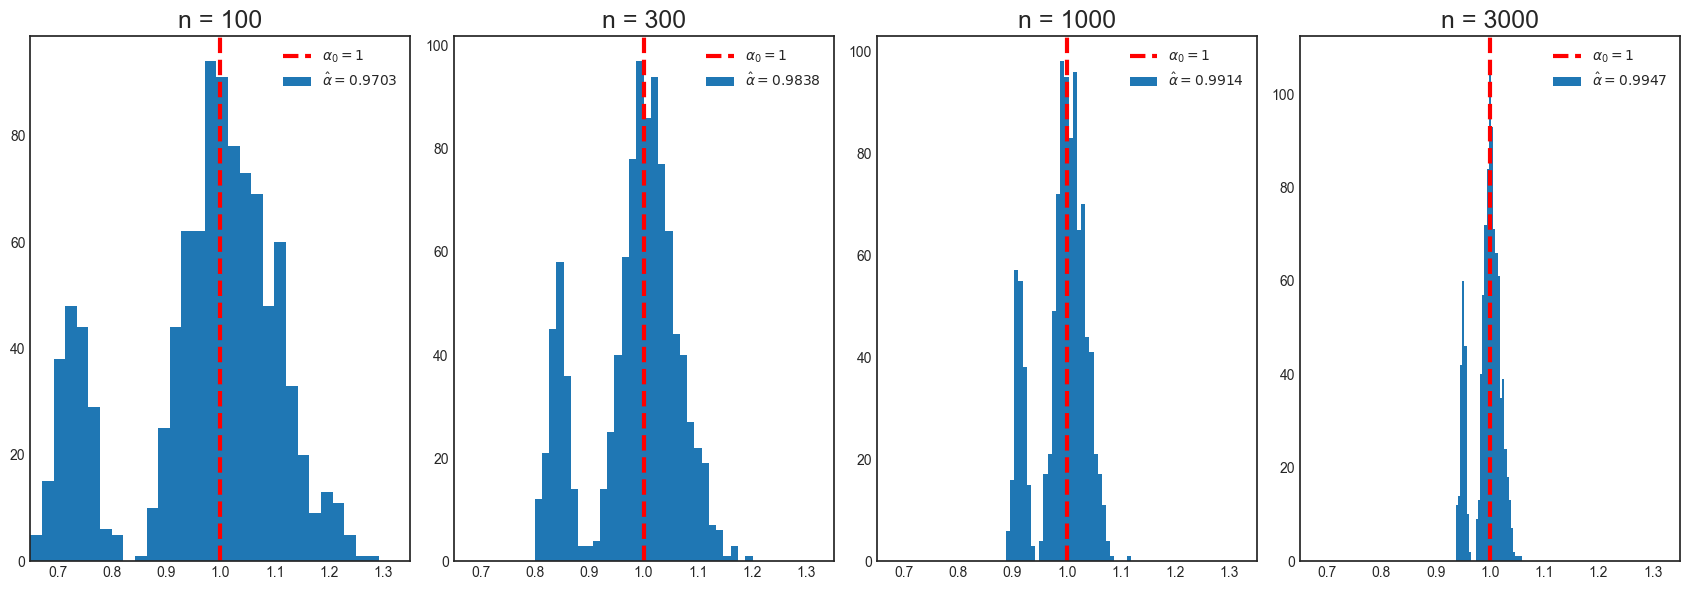

In [26]:
# Plot
plot_alpha(alpha, a)

Agora a distribuição de
não converge para uma normal quando o tamanho da amostra aumenta.

### Pré-teste e aprendizado de máquina

Como o aprendizado de máquina e o pré-teste estão relacionados? O melhor exemplo é o Lasso. Suponha que você tenha um conjunto de dados com muitas variáveis. Isso significa que você tem pouquíssimos graus de liberdade e suas estimativas de Mínimos Quadrados Ordinários (MQO) serão muito imprecisas. No extremo, você tem mais variáveis ​​do que observações, de modo que seu coeficiente de MQO é indefinido, já que não é possível inverter a matriz de design.
.

Nesse caso, talvez você queira fazer a seleção de variáveis. Uma maneira de fazer a seleção de variáveis ​​é por meio de pré-testes. Outra maneira é o Lasso. Uma terceira alternativa é usar métodos de aprendizado de máquina que não sofrem com essa maldição da dimensionalidade.

O propósito e o resultado do pré-teste e do Lasso são os mesmos:

você tem muitas variáveis
você exclui alguns deles da regressão / define seus coeficientes como zero
Como consequência, os problemas também são os mesmos, ou seja, viés pré-teste.

### Pós-Seleção Dupla


Considere novamente os dados
, onde o verdadeiro modelo é:

 

Gostaríamos de nos proteger contra o viés do pré-teste, se possível, para lidar com modelos de alta dimensão. Um bom caminho para motivar procedimentos que protejam contra o viés do pré-teste é uma discussão sobre regressão particionada clássica.

Considere uma regressão
sobre
e
.
é a variável unidimensional de interesse,
é um conjunto de variáveis ​​de controle de alta dimensão. Temos o seguinte procedimento:

Seleção do primeiro estágio : regressão
sobre
. Selecione as variáveis ​​estatisticamente significativas no conjunto
Seleção de forma reduzida : laço
sobre
. Selecione as variáveis ​​estatisticamente significativas no conjunto
Regress
sobre
e
Teorema : Seja
ser uma sequência de processos de geração de dados para
onde
depende de
. Para cada
, os dados são iid com
e
onde
e
. A escassez dos vetores 
,
é controlado por
com
. Suponha que condições de regularidade adicionais nos procedimentos de seleção do modelo e momentos das variáveis ​​aleatórias
,
,
conforme documentado em Belloni et al. (2014). Então, os intervalos de confiança, IC, do procedimento de seleção dupla pós-análise são uniformemente válidos. Ou seja, para qualquer nível de confiança

Para ter intervalos de confiança válidos, você quer que seu viés seja insignificante. Uma vez que
 

Se o viés for
 
então não há problema, pois é assintoticamente desprezível em relação à magnitude do intervalo de confiança. Se, no entanto, o viés for
 
então ele tem a mesma magnitude do intervalo de confiança e não desaparece assintoticamente.

A ideia da demonstração é usar regressão particionada. Uma maneira alternativa de pensar sobre o argumento é: limitar o viés das variáveis ​​omitidas. O viés da variável omitida vem do produto de duas grandezas relacionadas à variável omitida:

Sua correlação parcial com o resultado e
Sua correlação parcial com a variável de interesse.
Se ambas as correlações parciais forem
, então o viés das variáveis ​​omitidas é
 
, oferecido
. Em relação ao
 
taxa de convergência, o viés das variáveis ​​omitidas é insignificante.

No nosso caso de viés de variável omitida, queremos
 
. A seleção pós-dupla garante que

Seleção de forma reduzida (pré-teste): qualquer variável “ausente” tem
 
Seleção de primeiro estágio (adicional): qualquer variável “ausente” tem
 
Como consequência, enquanto o número de variáveis ​​omitidas for finito, o viés da variável omitida é

In [ ]:
# Pre-testing code
def post_double_selection(a, b, c, n, simulations=1000):
    np.random.seed(1)
    
    # Init
    alpha = {'Long': np.zeros((simulations,1)),
            'Short': np.zeros((simulations,1)),
            'Pre-test': np.zeros((simulations,1)),
            'Post-double': np.zeros((simulations,1))}

    # Loop over simulations
    for i in range(simulations):
        
        # Generate data
        x, y, z = generate_data(a, b, c, n)
        
        # Compute coefficients
        xz = np.concatenate([x,z], axis=1)
        alpha['Long'][i] = (inv(xz.T @ xz) @ xz.T @ y)[0][0]
        alpha['Short'][i] = inv(x.T @ x) @ x.T @ y
        
        # Compute significance of z on y (beta hat)
        t1 = t_test(y, xz, 1)
        
        # Compute significance of z on x (gamma hat)
        t2 = t_test(x, z, 0)
        
        # Select specification based on first test
        if np.abs(t1)>1.96:
            alpha['Pre-test'][i] = alpha['Long'][i]
        else:
            alpha['Pre-test'][i] = alpha['Short'][i]
            
        # Select specification based on both tests
        if np.abs(t1)>1.96 or np.abs(t2)>1.96:
            alpha['Post-double'][i] = alpha['Long'][i]
        else:
            alpha['Post-double'][i] = alpha['Short'][i]
    
    return alpha

Vamos agora repetir o mesmo exercício acima, mas também com seleção pós-dupla

In [ ]:
# Get pre_test alpha
alpha = post_double_selection(a, b, c, n)

for key, value in alpha.items():
    print('Mean alpha %s = %.4f' % (key, np.mean(value)))

In [ ]:
# Plot
plot_alpha(alpha, a)

Como podemos ver, a seleção pós-dupla resolveu o problema do pré-teste. Funciona para qualquer magnitude de
(em relação ao tamanho da amostra)?

Primeiro, vamos dar uma olhada no caso em que o tamanho da amostra é fixo e
mudanças.

In [ ]:
# Case 1: different betas and same sample size
b_sequence = b*np.array([0.1,0.3,1,3])
alpha = {}

# Get sequence
for k, b_ in enumerate(b_sequence):
    label = 'beta = %.2f' % b_
    alpha[label] = post_double_selection(a, b_, c, n)['Post-double']
    print('Mean alpha with beta=%.2f: %.4f' % (b_, np.mean(alpha[label])))

In [ ]:
# Plot
plot_alpha(alpha, a)

A seleção pós-dupla sempre seleciona a especificação correta, a regressão longa, mesmo quando
é muito pequeno.

Agora verificamos o mesmo, mas para fixo
e diferentes tamanhos de amostra.

In [ ]:
# Case 2: same beta and different sample sizes
n_sequence = [100,300,1000,3000]
alpha = {}

# Get sequence
for k, n_ in enumerate(n_sequence):
    label = 'N = %.0f' % n_
    alpha[label] = post_double_selection(a, b, c, n_)['Post-double']
    print('Mean alpha with n=%.0f: %.4f' % (n_, np.mean(alpha[label])))

In [ ]:
# Plot
plot_alpha(alpha, a)

A pós-seleção dupla sempre seleciona a especificação correta, a regressão longa, mesmo quando o tamanho da amostra é muito pequeno.

Por último, verificamos o caso de
proporcional a
 
.

In [ ]:
# Case 3: beta proportional to 1/sqrt(n) and different sample sizes
beta =  b * 30 / np.sqrt(n_sequence)

# Get sequence
alpha = {}
for k, n_ in enumerate(n_sequence):
    label = 'N = %.0f' % n_
    alpha[label] = post_double_selection(a, beta[k], c, n_)['Post-double']
    print('Mean alpha with n=%.0f: %.4f' % (n_, np.mean(alpha[label])))

In [ ]:
# Plot
plot_alpha(alpha, a)

Mais uma vez, a pós-seleção dupla sempre seleciona a especificação correta, a regressão longa.

Pós-seleção dupla e aprendizado de máquina
Como vimos no final da seção anterior, o Lasso pode ser usado para realizar a seleção de variáveis ​​em cenários de alta dimensão. Portanto, a seleção pós-dupla resolve o problema de viés do pré-teste nesses cenários. O procedimento de seleção pós-dupla com o Lasso é:

Seleção da primeira fase : laço
sobre
. Deixe que as variáveis ​​selecionadas sejam coletadas no conjunto
Seleção de forma reduzida : laço
sobre
. Deixe que as variáveis ​​selecionadas sejam coletadas no conjunto
Regress
sobre
e

### Aprendizado de máquina duplo/desviés

Esta seção foi retirada de Chernozhukov, V., Chetverikov, D., Demirer, M., Duflo, E., Hansen, C., Newey, W., & Robins, J. (2018). “ Aprendizado de máquina duplo/desviado para tratamento e parâmetros estruturais ” .

Considere o seguinte modelo parcialmente linear


onde
é a variável de resultado,
é o tratamento de interesse e
é um conjunto de controles potencialmente de alta dimensão.

Abordagem ingênua
Uma abordagem ingênua para estimativa de
usar métodos de ML seria, por exemplo, construir um estimador de ML sofisticado
para aprender a função de regressão
+
.

Divida a amostra em duas: amostra principal e amostra auxiliar
Use a amostra auxiliar para estimar
Use a amostra principal para calcular o componente ortogonalizado de
sobre
: $\que u = \esquerda(Y_{i}-\que{g} {0}\esquerda(X {i}\direita)\direita)$
Use a amostra principal para estimar o estimador MCO residualizado
$$ \que{\beta} {0}=\esquerda(\frac{1}{n} \soma {i \em I} D_{i}^{2}\direita)^{-1} \frac{1}{n} \soma_{i \em I} D_{i} \que u_i $$

Este estimador terá dois problemas:

Taxa de convergência lenta, ou seja, mais lenta que
Será tendencioso porque estamos empregando estimadores regularizados de alta dimensão (por exemplo, estamos fazendo seleção de variáveis)
Ortogonalização
Agora considere uma segunda construção que emprega uma formulação ortogonalizada obtida pela parcialização direta do efeito de
de
para obter o regressor ortogonalizado
.

Divida a amostra em duas: amostra principal e amostra auxiliar

Use a amostra auxiliar para estimar
de


Use a amostra auxiliar para estimar
de


Use a amostra principal para calcular o componente ortogonalizado de
sobre
como


Use a amostra principal para estimar o estimador OLS duplamente residualizado como

$$ \que{\beta} {0}=\esquerda(\frac{1}{n} \soma {i \em I} \que v_i D_{i} \direita)^{-1} \frac{1}{n} \soma_{i \em I} \que v_i \esquerda( Y - \que g_0(X) \direita) $$

O estimador é imparcial, mas ainda apresenta uma taxa de convergência menor devido à divisão da amostra. O problema é resolvido invertendo a amostra dividida, reestimando o coeficiente e calculando a média das duas estimativas. Observe que este procedimento é válido, pois as duas estimativas são independentes pelo procedimento de divisão da amostra.

Aplicação para AJR02
Nesta seção, replicaremos 6.3 do artigo “ Aprendizado de máquina duplo/desviado ” baseado em Acemoglu, Johnson, Robinson (2002), “ As origens coloniais do desenvolvimento comparativo ” .

Primeiro carregamos o conjunto de dados

In [ ]:
# Load Acemoglu Johnson Robinson Dataset
df = pd.read_csv('data/AJR02.csv',index_col=0)
df.head()

In [ ]:
df.info()

Em seu artigo, a AJR observa que sua estratégia de IV será invalidada se outros fatores também forem altamente persistentes e relacionados ao desenvolvimento das instituições dentro de um país e ao PIB do país. Um dos principais candidatos a tal fator, como eles discutem, é a geografia. A AJR aborda isso assumindo que o efeito de confusão da geografia é adequadamente capturado por um termo linear de distância do equador e um conjunto de variáveis ​​fictícias continentais.

Eles incluem seus resultados na tabela 2.

In [ ]:
# Add constant term to dataset
df['const'] = 1

# Create lists of variables to be used in each regression
X1 = df[['const', 'Exprop']]
X2 = df[['const', 'Exprop', 'Latitude', 'Latitude2']]
X3 = df[['const', 'Exprop', 'Latitude', 'Latitude2', 'Asia', 'Africa', 'Namer', 'Samer']]
y = df['GDP']

# Estimate an OLS regression for each set of variables
reg1 = sm.OLS(y, X1, missing='drop').fit()
reg2 = sm.OLS(y, X2, missing='drop').fit()
reg3 = sm.OLS(y, X3, missing='drop').fit()

Vamos replicar a Tabela 2 no AJR.

In [ ]:
# Make table 2
def make_table_2():

    info_dict={'No. observations' : lambda x: f"{int(x.nobs):d}"}

    results_table = summary_col(results=[reg1,reg2,reg3],
                                float_format='%0.2f',
                                stars = True,
                                model_names=['Model 1','Model 2','Model 3'],
                                info_dict=info_dict,
                                regressor_order=['const','Exprop','Latitude','Latitude2'])
    return results_table

In [ ]:
table_2 = make_table_2()
table_2

Usar DML nos permite relaxar essa suposição e substituí-la por uma suposição mais fraca de que a geografia pode ser suficientemente controlada por uma função desconhecida de distância do equador e de modelos continentais, o que pode ser aprendido por métodos de ML.

Em particular, a nossa estrutura é


Para que o procedimento de aprendizagem de máquina duplo/desviés seja

Divida a amostra em duas: amostra principal e amostra auxiliar

Use a amostra auxiliar para estimar
de


Use a amostra auxiliar para estimar
de


Use a amostra principal para calcular o componente ortogonalizado de
sobre
como


Use a amostra principal para estimar o estimador OLS duplamente residualizado como

$$ \hat{\beta} {0}=\left(\frac{1}{n} \sum {i \in I} \hat v_i \times {Exprop} {i} \right)^{-1} \frac{1}{n} \sum {i \in I} \hat v_i \times \left( {PIB} - \hat g_0({geografia}) \right) $$

Como empregamos uma estratégia de variável instrumental , substituímos
com
no primeiro estágio.

In [ ]:
# Generate variables
D = df['Exprop'].values.reshape(-1,1)
X = df[['const', 'Latitude', 'Latitude2', 'Asia', 'Africa', 'Namer', 'Samer']].values
y = df['GDP'].values.reshape(-1,1)
Z = df[['const', 'Latitude', 'Latitude2', 'Asia', 'Africa', 'Namer', 'Samer','logMort']].values

In [ ]:
def estimate_beta(algorithm, alg_name, D, X, y, Z, sample):

    # Split sample
    D_main, D_aux = (D[sample==1], D[sample==0])
    X_main, X_aux = (X[sample==1], X[sample==0])
    y_main, y_aux = (y[sample==1], y[sample==0])
    Z_main, Z_aux = (Z[sample==1], Z[sample==0])

    # Residualize y on D
    b_hat = inv(D_aux.T @ D_aux) @ D_aux.T @ y_aux
    y_resid_aux = y_aux - D_aux @ b_hat
    
    # Estimate g0
    alg_fitted = algorithm.fit(X=X_aux, y=y_resid_aux.ravel())
    g0 = alg_fitted.predict(X_main).reshape(-1,1)

    # Compute v_hat
    u_hat = y_main - g0

    # Estimate m0
    alg_fitted = algorithm.fit(X=Z_aux, y=D_aux.ravel())
    m0 = algorithm.predict(Z_main).reshape(-1,1)
    
    # Compute u_hat
    v_hat = D_main - m0

    # Estimate beta
    beta = inv(v_hat.T @ D_main) @ v_hat.T @ u_hat
        
    return beta 

In [ ]:
def ddml(algorithm, alg_name, D, X, y, Z, p=0.5, verbose=False):
    
    # Expand X if Lasso or Ridge
    if alg_name in ['Lasso   ','Ridge   ']:
        X = PolynomialFeatures(degree=2).fit_transform(X)

    # Generate split (fixed proportions)
    split = np.array([i in train_test_split(range(len(D)), test_size=p)[0] for i in range(len(D))])
    
    # Compute beta
    beta = [estimate_beta(algorithm, alg_name, D, X, y, Z, split==k) for k in range(2)]
    beta = np.mean(beta)
     
    # Print and return
    if verbose:
        print('%s : %.4f' % (alg_name, beta))
    return beta

In [ ]:
# Generate sample split
p = 0.5
split = np.random.binomial(1, p, len(D))

Inspecionamos diferentes algoritmos. Em particular, consideramos:

Regressão Lasso
Regressão de Ridge
Árvores de Regressão
Floresta aleatória
Florestas Impulsionadas

In [ ]:
# List all algorithms
algorithms = {'Ridge   ': Ridge(alpha=.1),
              'Lasso   ': Lasso(alpha=.01),
              'Tree    ': DecisionTreeRegressor(),
              'Forest  ': RandomForestRegressor(n_estimators=30),
              'Boosting': GradientBoostingRegressor(n_estimators=30)}

Vamos comparar os resultados.

In [ ]:
# Loop over algorithms
for alg_name, algorithm in algorithms.items():
    ddml(algorithm, alg_name, D, X, y, Z, verbose=True)

Os resultados são extremamente voláteis.

In [ ]:
# Repeat K times
def estimate_beta_median(algorithms, D, X, y, Z, K):
    
    # Loop over algorithms
    for alg_name, algorithm in algorithms.items():
        betas = []
            
        # Iterate n times
        for k in range(K):
            beta = ddml(algorithm, alg_name, D, X, y, Z)
            betas = np.append(betas, beta)
    
        print('%s : %.4f' % (alg_name, np.median(betas)))

Vamos tentar usar a mediana para ter um estimador mais estável.

In [ ]:
np.random.seed(123)

# Repeat 100 times and take median
estimate_beta_median(algorithms, D, X, y, Z, 100)

Os resultados diferem um pouco dos do artigo, mas pelo menos são mais próximos.